In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from patsy import dmatrices
import pymc3 as pm

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

#### Causal Effects in Non-Experimental Studies
Rubin model of causal effects.
Structural Equation Modeling. 

Randomised control experiments have two big issues, self-selection bias, cost prohibitiveness and ethcicality.

The goal of statistical adjustment is to approcimate what a randomised experiment would achieve. There is many statistical tools that can be used to adjust available data to be more conducive to causal estimation. 

Rubin Causal Model (Regression)

Covariates are that which are being controlled for, treatment is the remaining input that changed as a result of some effect. Covariates can also be created by interacting with the treatment, this is automatically the case in most machine learning models. Using the rubin causal model you make an unconfoundedness assumption. The rubin causal models runs a regression to weed out the effect the treatment has on the outcome. Confounding variables are those that effect both the treatment and the outcome. Unconfoundedness mean that there are no such qualities on which you potential outcomes depend that also relate to the selection into treatment. Conditional on a sufficient set of covariates, X, the potential outcomes are independent of treatment, in which case there are no common causes of the potential oucomes and the treatment. Its important to note that this is an assumption that cannot be proven. Once this assumption holds, it is possible to identify the causal effect. Rubin came up with the term unconfoudedness. 

Matching (Non-parametric)

Matching is a statistical adjustment technique used when you have imbalanced data sets. You normally have a lot of controls but limited amount of treatment samples. Then killing two birds with one stone, that is to remove the imbalance in these groups and to approximate what you might have got had you implemented a randomised control experiment you can use propensity score matching and distance matching. Propensity matching is the most common method but there are naturally criticisms against using it blindly. 

-- Propensity Score Matching 

Propensity scores, determine each subject’s probability of being assigned to the treatment that they received given the set of observed covarites. If you then match on these probabilities (propensity scores), then what you have done is taken subjects who were equally likely to be assigned to the each treatment and compared them with one another, effectively comparing apples to apples.You may ask why not exactly match on the covariates (e.g. make sure you match 40 year old men in good health in treatment 1 with 40 year old men in good health in treatment 2)? This works fine for large samples and a few covariates, but it becomes nearly impossible to do when the sample size is small. Once built, we can then estimate propensities for both of our treatment and control groups. Hopefully we'll find that there are some subjects in the treatment group with low propensity, but the majority have high propensity (they did actually end up in the treatment group), and the opposite for the control group.

We would then find paired (or many) matches in the control group for each sample in the treatment group picking matches that minimize the differences in propensity score. Since we're dealing with estimates, it's ok if this isn't an optimal match, and we can usually use a simple algorithm like a greedy random match. Now, all this being said, the Achilles heel of propensity score is the assumption of no unobserved confounders. This assumption states that you have not failed to include in any covariates in your adjustment that are potential confounders.

Lastly, matching has come a long way since 1983. Check out Jas Sekhon's webpage to learn about his genetic matching algorithm.


The short answer is that propensity scores are normally not any better than the equivalent regression model, but have some statistical advantage. Propensity scores are best understood as a data reduction method. They are an effective means to reduce many covariates into a single score that can be used to adjust an effect of interest for a set of variables. In doing so, you save degrees of freedom by adjusting for a single propensity score rather than multiple covariates. This presents a statistical advantage, certainly, but nothing more.


Distance Matching

Using a measure like Mahalanobis distance is also an effective way to match groups, and has the bonus of not introducing an intermediate model. We would look at picking a match that minimizes distance between covariates. 


Difference Regression and Matching

One big difference is that regression "controls for" those characteristics in a linear fashion. Matching by propensity scores eliminates the linearity assumption, but, as some observations may not be matched, you may not be able to say anything about certain groups.

For example, if you are studying a worker training program, you may have all the enrollees be men, but the control, non-participant population be composed of men and women. Using regression, you could regress, income, say, on a participation indicator variable and a male indicator. You would use all your data and could estimate the income of a female had she participated in the program.

If you were doing matching, you could only match men to men. As a result, you wouldn't be using any women in your analysis and your results wouldn't pertain to them.

Regression can extrapolate using the linearity assumption, but matching cannot. All the other assumptions are essentially the same between regression and matching. The benefit of matching over regression is that it is non-parametric (except you do have to assume that you have the right propensity score, if that is how you are doing your matching).



The data is a population survey including some basic demographics about each subject, and information about their salary. Our treatment group is filled with subjects who partook in an occupational training program. We expect to see that having gone through training has a positive end effect on salary.

In [2]:
import pandas as pd
import numpy as np
# NSW Data Files (Dehejia-Wahha Sample)
# http://users.nber.org/~rdehejia/data/nswdata2.html

cps = pd.read_csv('cps_controls.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'
    ])

original_treatment = pd.read_csv('nswre74_treated.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'        
    ])

unmatched_raw = pd.concat([
        cps, original_treatment
    ], axis=0)

unmatched_raw['u74'] = (unmatched_raw.re74 == 0).astype(np.int32)
unmatched_raw['u75'] = (unmatched_raw.re75 == 0).astype(np.int32)

unmatched_raw[['re74_div', 're75_div', 're78_div']] = unmatched_raw[['re74', 're75', 're78']] / 1000

unmatched_raw.shape

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


(16177, 15)

In [3]:
cps.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869


In [4]:
original_treatment.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


In [5]:
unmatched_raw.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,0,0,21.516670,25.243550,25.564670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,0,0,3.175971,5.852565,13.496080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,0,0,23.039020,25.130760,25.564670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,0,0,24.994370,25.243550,25.564670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,0,0,1.669295,10.727610,9.860869


In [6]:
## Good way to put in HTML table for markdown. 
print(unmatched_raw.head().to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>treat</th>
      <th>age</th>
      <th>educ</th>
      <th>black</th>
      <th>hisp</th>
      <th>married</th>
      <th>nodegr</th>
      <th>re74</th>
      <th>re75</th>
      <th>re78</th>
      <th>u74</th>
      <th>u75</th>
      <th>re74_div</th>
      <th>re75_div</th>
      <th>re78_div</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.0</td>
      <td>45.0</td>
      <td>11.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>21516.670</td>
      <td>25243.550</td>
      <td>25564.670</td>
      <td>0</td>
      <td>0</td>
      <td>21.516670</td>
      <td>25.243550</td>
      <td>25.564670</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.0</td>
      <td>21.0</td>
      <td>14.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>3175.971</td>
      <td>5852

In [7]:
unmatched_raw.tail()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
180,1.0,33.0,12.0,1.0,0.0,1.0,0.0,20279.95,10941.35,15952.600,0,0,20.27995,10.94135,15.952600
181,1.0,25.0,14.0,1.0,0.0,1.0,0.0,35040.07,11536.57,36646.950,0,0,35.04007,11.53657,36.646950
182,1.0,35.0,9.0,1.0,0.0,1.0,1.0,13602.43,13830.64,12803.970,0,0,13.60243,13.83064,12.803970
183,1.0,35.0,8.0,1.0,0.0,1.0,1.0,13732.07,17976.15,3786.628,0,0,13.73207,17.97615,3.786628
184,1.0,33.0,11.0,1.0,0.0,1.0,1.0,14660.71,25142.24,4181.942,0,0,14.66071,25.14224,4.181942


There are a lot of samples, and a lot of imbalance between the control and treatment group. We have only 185 treatment observations, and 15,992 control observations. It's likely that if we built a causal model on these all of these samples, that we'd see the large number of control samples wash out the value of the treatment indicator. Thus this is a great dataset to use with matching.

If we look at the compared density plots of the controls and the treatments we see the following. The density plot (probability density function PDF) takes in continuous values. The cummulative distribution fuction takes in discrete or continuous values and accumulats so creates an S-curve. A Density Plot visualises the distribution of data over a continuous interval. An advantage Density Plots have over Histograms is that they're better at determining the distribution shape because they're not affected by the number of bins used 

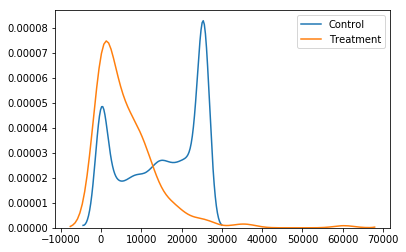

In [8]:
import seaborn as sns
## RE74 (earnings in 1974), RE75 (earnings in 1975), and RE78 (earnings in 1978)

sns.kdeplot(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control')
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment');

Unfortunately this hides how imbalanced these two sets are. If we look instead at a histogram of our data (which doesn't normalize like the above plot) we will see the actual imbalance.

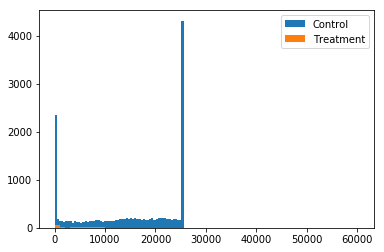

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.hist(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control', bins=60);
plt.hist(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment', bins=60);
plt.legend();

# Using the `causalinference` library

The first thing we're going to do is look at a well made library implemented to specifically deal with this type of causal model, the causalinference package in python. It's very straightforward to run several models quickly.

In [10]:
from causalinference import CausalModel

In [11]:
causal_model = CausalModel(
    X=unmatched_raw[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74_div', 're75_div', 'u74', 'u75']].values, 
    D=unmatched_raw.treat.values, # participant in occu. train prog. 
    Y=unmatched_raw.re78_div.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()
print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)


Summary Statistics

                       Controls (N_c=373)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        4.814        6.084        6.038        8.006        1.224

                       Controls (N_c=373)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       26.416       11.046       25.765        7.355       -0.069
             X1       10.595        2.698       10.221        2.066       -0.156
             X2        0.882        0.323        0.973        0.162        0.357
             X3        0.118        0.323        0.027        0.162       -0.357
             X4        0.214        0.411        0.134        0.342       -0.212
      

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/weighting.py:23: FutureWarning:

## Using our own Bayesian Model

For $y \in \mathbb{R}$, and $\mathbf{x} \in \mathbb{R}^M$

For $N$ data points, we have $(\mathbf{X}, \mathbf{y}) = \{(\mathbf{x}_n, y_n)\}$.

With the following distributions

$$
\begin{align*}
p(\mathbf{w}) &= \mathcal{N}(\mathbf{w} | 0, \sigma_w^2 \mathbf{I}) \\
p(b) &= \mathcal{N}(b | 0, \sigma_b^2) \\
p(\mathbf{y} | \mathbf{w}, b, \mathbf{X}) &= \prod_{n=1}^N \mathcal{N} (y_n | \mathbf{x}_n^{\intercal} \mathbf{w} + b, \sigma_y^2)
\end{align*}
$$

## Propensity Matching

In [12]:
# without outcome
propensity_formula = "treat ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re75_div + re74_div + I(re74_div*re75_div)"

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# intermediate formula
propensity_model = smf.glm(formula=propensity_formula, data=unmatched_raw, family=sm.families.Binomial()).fit()
propensity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  treat   No. Observations:                16177
Model:                            GLM   Df Residuals:                    16165
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -473.41
Date:                Mon, 16 Jul 2018   Deviance:                       946.82
Time:                        17:30:18   Pearson chi2:                 8.10e+03
No. Iterations:                    12                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -6.6364      0.825     -8.045      0.000      -8.253      -5.020
age                       -0.0191      0.011     -1.788      0.074      -0.040       0.002
educ                       0.0195      0.048      0.404      0.686      -0.075       0.114
black                      4.2899      0.263     16.329      0.000       3.775       4.805
hisp                       1.8322      0.394      4.655      0.000       1.061       2.604
married                   -0.9954      0.240     -4.147      0.000      -1.466      -0.525
nodegr                     0.9100      0.274      3.318      0.001       0.372       1.448
u74                        1.7318      0.280      6.178      0.000       1.182       2.281
u75                        0.3934      0.253      1.555      0.120      -0.102       0.889
re75_div                  -0.0871      0.056     -1.559      0.119      -0.197       0.022
re74_div                   0.0985      0.033      2.968      0.003       0.033       0.164
I(re74_div * re75_div)    -0.0072      0.004     -1.800      0.072      -0.015       0.001
==========================================================================================
"""

In [14]:
from patsy import dmatrices

_, X_propensity = dmatrices(propensity_formula, unmatched_raw, return_type='dataframe')

In [15]:
propensities = propensity_model.predict(exog=X_propensity)

In [16]:
(propensities < 0.5).sum()

16069

In [17]:
(propensities > 0.5).sum()

108

In [18]:
unmatched_raw.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,0,0,21.516670,25.243550,25.564670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,0,0,3.175971,5.852565,13.496080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,0,0,23.039020,25.130760,25.564670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,0,0,24.994370,25.243550,25.564670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,0,0,1.669295,10.727610,9.860869


In [19]:
## there are 59 TPs in treatment, enough to espouse valid matching.
## thus 108-59, 59 in non-treatment (control, cps)
unmatched_raw.loc[propensities > 0.5].treat.sum() # similar index

59.0

In [20]:
split = cps.shape[0]

In [21]:
propensities.head()

0    0.000011
1    0.000829
2    0.000005
3    0.000007
4    0.000406
dtype: float64

In [22]:
## simply reverses initial concatanation
treatment = np.expand_dims(propensities[split:], 1)
control = np.expand_dims(propensities[:split], 1)

treatment.shape, control.shape

((185, 1), (15992, 1))

Calculating the distance in propensity of each treatment sample to each control sample

In [23]:
from scipy.spatial.distance import cdist
distances = cdist(treatment, control)

In [24]:
distances.shape

(185, 15992)

From this fitted model, we can then make propensity score estimates, and come up with some matches.

In [25]:
from scipy.optimize import linear_sum_assignment
# # Computing an optimal match between the two groups
# # it is going to fit to the lenght of the smallest sample
treatment_idx, control_idx = linear_sum_assignment(distances)
treatment_idx, control_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [26]:
## Selecting the matches by index
treatment_data = unmatched_raw[split:].iloc[treatment_idx]
control_data = unmatched_raw[:split].iloc[control_idx]
print(treatment_data.head())
print('----')
print(control_data.head())

   treat   age  educ  black  hisp  married  nodegr  re74  re75        re78  \
0    1.0  37.0  11.0    1.0   0.0      1.0     1.0   0.0   0.0   9930.0460   
1    1.0  22.0   9.0    0.0   1.0      0.0     1.0   0.0   0.0   3595.8940   
2    1.0  30.0  12.0    1.0   0.0      0.0     0.0   0.0   0.0  24909.4500   
3    1.0  27.0  11.0    1.0   0.0      0.0     1.0   0.0   0.0   7506.1460   
4    1.0  33.0   8.0    1.0   0.0      0.0     1.0   0.0   0.0    289.7899   

   u74  u75  re74_div  re75_div   re78_div  
0    1    1       0.0       0.0   9.930046  
1    1    1       0.0       0.0   3.595894  
2    1    1       0.0       0.0  24.909450  
3    1    1       0.0       0.0   7.506146  
4    1    1       0.0       0.0   0.289790  
----
       treat   age  educ  black  hisp  married  nodegr      re74        re75  \
11544    0.0  46.0  11.0    1.0   0.0      1.0     1.0     0.000     0.00000   
6044     0.0  21.0  12.0    1.0   0.0      0.0     0.0  7012.216  1389.29000   
13363    0.0  34

Here, we compute an optimal match, though this is not always very efficient (or needed). As mentioned earlier typically we can compute a random greedy match with or without replacement and achieve similar results. This will run much faster since it's just a simple loop. Since our treatment group is small enough I wanted to try the optimal matching method.

Now if we compare our density plots we see much more similarity in our groups,

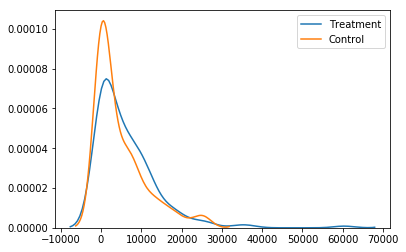

In [27]:
sns.kdeplot(treatment_data.re78, label='Treatment')
sns.kdeplot(control_data.re78, label='Control')

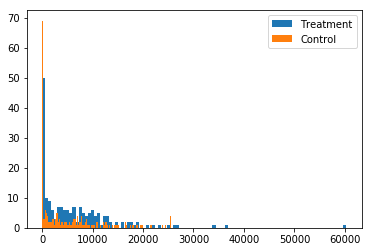

In [28]:
plt.hist(treatment_data.re78, label='Treatment', bins=100)
plt.hist(control_data.re78, label='Control', bins=100)
plt.legend();

Now that we've got a treatment & matched control group we can put these together and build a model to estimate treatment effect.

In [29]:
data_propensity_matched = pd.concat([
        treatment_data,
        control_data
        ], axis=0)
data_propensity_matched.shape

(370, 15)

In [30]:
causal_formula = "re78_div ~ treat + age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div"

## Mahalanobis Distance Matching

In [45]:
treatment = X_propensity[split:]
control = X_propensity[:split]

treatment.shape, control.shape

((185, 12), (15992, 12))

# Bonus - Estimating the counterfactual observations

Suppose we build two models,

$$
\begin{aligned}
\hat{Y}_1(1) &= \alpha_1 + \beta_1 X_i(1) + \epsilon_i \\
\hat{Y}_0(0) &= \alpha_0 + \beta_0 X_i(0) + \epsilon_i
\end{aligned}
$$

where the coefficients of $\hat{Y}_1$ are learned exclusively on samples of $X$ where we've observed $Y(1)$, and those of $\hat{Y}_2$ are likewise are learned from samples where $Y(0)$.

In [51]:
treatment_propensity.shape

(185, 15)

In [52]:
control_propensity.shape

(185, 15)

In [46]:
treatment_propensity = data_propensity_matched[data_propensity_matched.treat == 1]
control_propensity = data_propensity_matched[data_propensity_matched.treat == 0]

In [47]:
formula = 're78_div ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div'

In [48]:
treatment_model = smf.glm(formula=formula, data=treatment_propensity).fit()

In [49]:
control_model = smf.glm(formula=formula, data=control_propensity).fit()

Now, looking back at the fundamental problem of causal inference, we want to estimate what the counterfactual outcomes would be, e.g. fill in the gaps.

What if we swap our data and estimate the effect from the two groups using the corresponding models?

$$
\begin{align*}
\hat{Y}_1(0) = \alpha_1 + \beta_1 X_i(0) + \epsilon_i \\
\hat{Y}_0(1) = \alpha_0 + \beta_0 X_i(1) + \epsilon_i
\end{align*}
$$

In [53]:
Y_treatment, X_treatment = dmatrices(causal_formula, treatment_propensity, return_type='dataframe')
Y_control, X_control = dmatrices(causal_formula, control_propensity, return_type='dataframe')

In [54]:
Y_0 = np.expand_dims(treatment_model.predict(exog=X_control), 1)
Y_1 = np.expand_dims(control_model.predict(exog=X_treatment), 1)

Now we can define $\hat{\tau}_i = Y_i - \hat{Y}_1(0)$ for our control group, and $\hat{\tau}_i = \hat{Y}_0(1) - Y_i$ for our treatment group.

We can then calculate average treatment effect as $\hat{\tau} = \frac{1}{N} \sum_{i=1}^N \hat{\tau}_i$.

In [55]:
## This matching method produces the same outcome as that in the causal inference module

np.concatenate([
    (Y_treatment - Y_1),    
    (Y_0 - Y_control)        
]).mean()

1.5483643168987677

Once again we get a very similar treatment effect. The rationale here is that our earlier regression models are largely derived from this idea.

We've seen a few different implementations of the Rubin model of causal effect, and looked at matching with propensity scores, and Mahalanobis distance. With all of these models we've come up with similar positive treatment effects. Note, that if we had just used the OLS or Matching treatment effects from the causalinference library we might not have claimed any significance. However, given that each of these models comes up with similar treatment effects, we can be a bit more confident that there is in fact some positive treatment effect. In fact, with our Bayesian models we're relatively sure that there's a positive effect P(treat>0)≈0.97

The difference between the propensity matching and Mahalanobis distance matching was very small. In other models this might not be the case and there might be good reasons to use one over the other. In general propensity matching is a very popular approach for matching, but one might want to be careful about understanding the strong ignorability assumption that goes along. (The ignorability assumption simply means that the choice to assign to the control group or the treatment group can be assumed to be effectively random when conditioned on observable characteristics of the study objects, and that missing data can be treated as occurring effectively at random) It in effect suffers a similar issue that confouding cause  in the rubin model. 

Lastly, the Rubin model of causal effect is relatively simple, and more advanced approaches have been studied with structural equation modeling. 

# References

- Lalonde, R. J. (1986). Evaluating the Econometric Evaluations of Training Programs with Experimental Data. Journal of Chemical Information and Modeling, 76(4), 604–620. http://doi.org/10.1017/CBO9781107415324.004
- Gelman, a, & Hill, J. (2007). Data analysis using regression and multilevel/hierarchical models. Policy Analysis, 1–651. http://doi.org/10.2277/0521867061
- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences an Introduction. Cambridge University Press. Retrieved from http://www.cambridge.org/US/academic/subjects/statistics-probability/statistical-theory-and-methods/causal-inference-statistics-social-and-biomedical-sciences-introduction